# Setup environment

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '/content/drive/MyDrive/Colab Notebooks/Research/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)



Mounted at /content/drive


In [2]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

# Preprocess Data

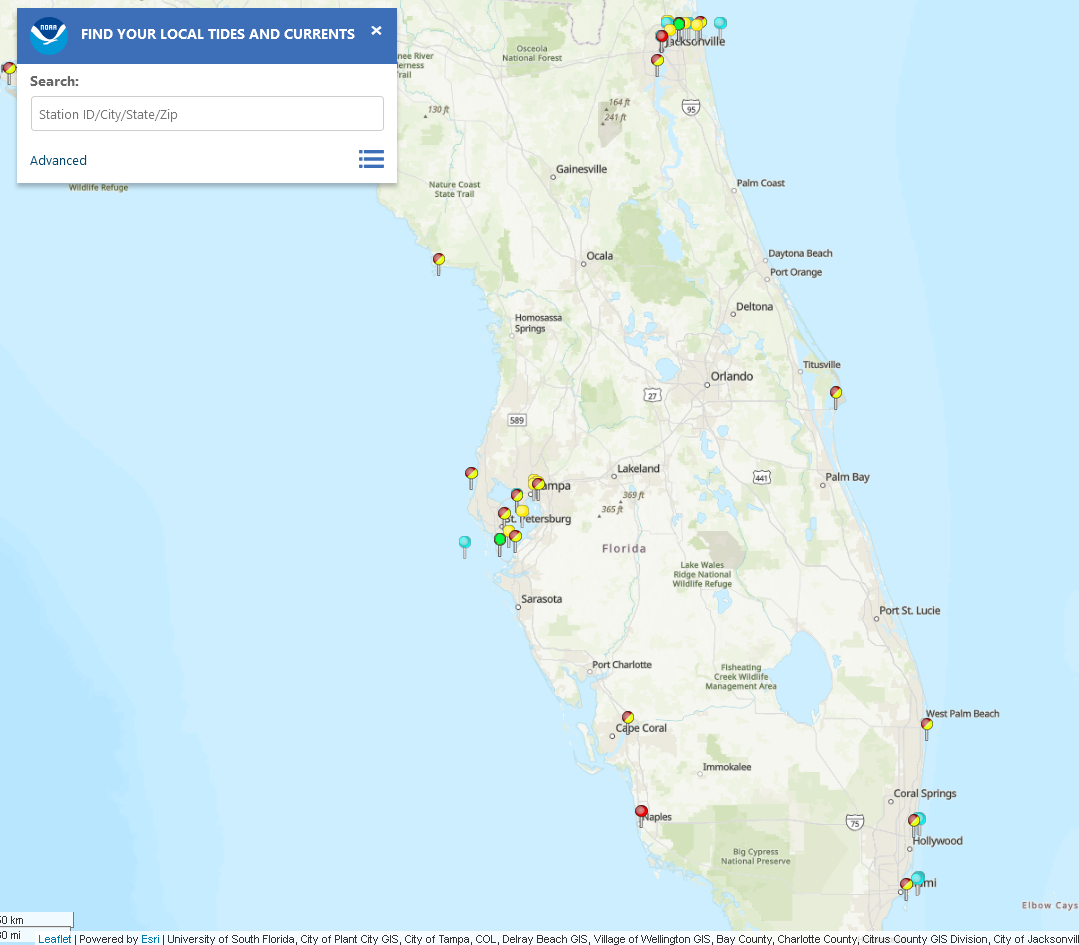

In [14]:
import pandas as pd
import numpy as np

# station_dict = ['jx0102', 'mi0101', 'mi0301', 'pe0101']
# station_coords = {
#     'pe0101': {'latitude': 26 + 5.5 / 60, 'longitude': -(80 + 4.8 / 60)},
#     'mi0301': {'latitude': 25 + 45.7 / 60, 'longitude': -(80 + 5.8 / 60)},
#     'jx0102': {'latitude': 30 + 23.6 / 60, 'longitude': -(81 + 18.2 / 60)},
#     'mi0101': {'latitude': 25 + 46.1 / 60, 'longitude': -(80 + 5.0 / 60)}
# }
station_dict = ['COI0419', 'COI0420', 'COI0511', 'COI1203']

station_coords = {
    'COI0419': {'latitude': 59 + 83933 / 1e5, 'longitude': -(152 + 36833 / 1e5)},  # 59.83933, -152.36833
    'COI0420': {'latitude': 59 + 8187 / 1e4, 'longitude': -(152 + 15553 / 1e5)},   # 59.8187, -152.15553
    'COI0511': {'latitude': 60 + 2327 / 1e5, 'longitude': -(152 + 12018 / 1e5)},   # 60.02327, -152.12018
    'COI1203': {'latitude': 59 + 74383 / 1e5, 'longitude': -(152 + 3417 / 1e5)}    # 59.74383, -152.03417
}

locations = np.array([[coord['latitude'], coord['longitude']] for coord in station_coords.values()])
print(locations)
time = {}
speed = {}
direction = {}

max_ind = 452
for station in station_dict:
    data = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Research/data/{station}.csv')
    data.columns = data.columns.str.strip()

    time[station] = np.arange(1,  max_ind + 1)  # in minutes
    speed[station] = data['Speed (knots)'].values[:max_ind]
    direction[station] = data['Dir (true)'].values[:max_ind]

    # Check for null values
    # has_null_speed = pd.isnull(speed[station]).any()
    # has_null_direction = pd.isnull(direction[station]).any()

    # print("Speed array has null values:", has_null_speed)
    # print("Direction array has null values:", has_null_direction)
    # print(speed[station])
    # print(f'Shape of {station}')
    print(station)
    print(time[station].shape)
    print(speed[station].shape)
    print(direction[station].shape)
    # print('\n')


# # Convert time vector to minutes for discrete vector
# time = data['Date/Time'].dt.round('T').dt.minute.values
# initial_time = data['Date/Time'].iloc[0]
# time = ((data['Date/Time'] - initial_time).dt.total_seconds() / 60).round().astype(int)

# print("Time (in minutes):", time)
# print("Speed (knots):", speed)
# print("Direction (true):", direction)


[[  59.83933 -152.36833]
 [  59.8187  -152.15553]
 [  60.02327 -152.12018]
 [  59.74383 -152.03417]]
COI0419
(452,)
(452,)
(452,)
COI0420
(452,)
(452,)
(452,)
COI0511
(452,)
(452,)
(452,)
COI1203
(452,)
(452,)
(452,)


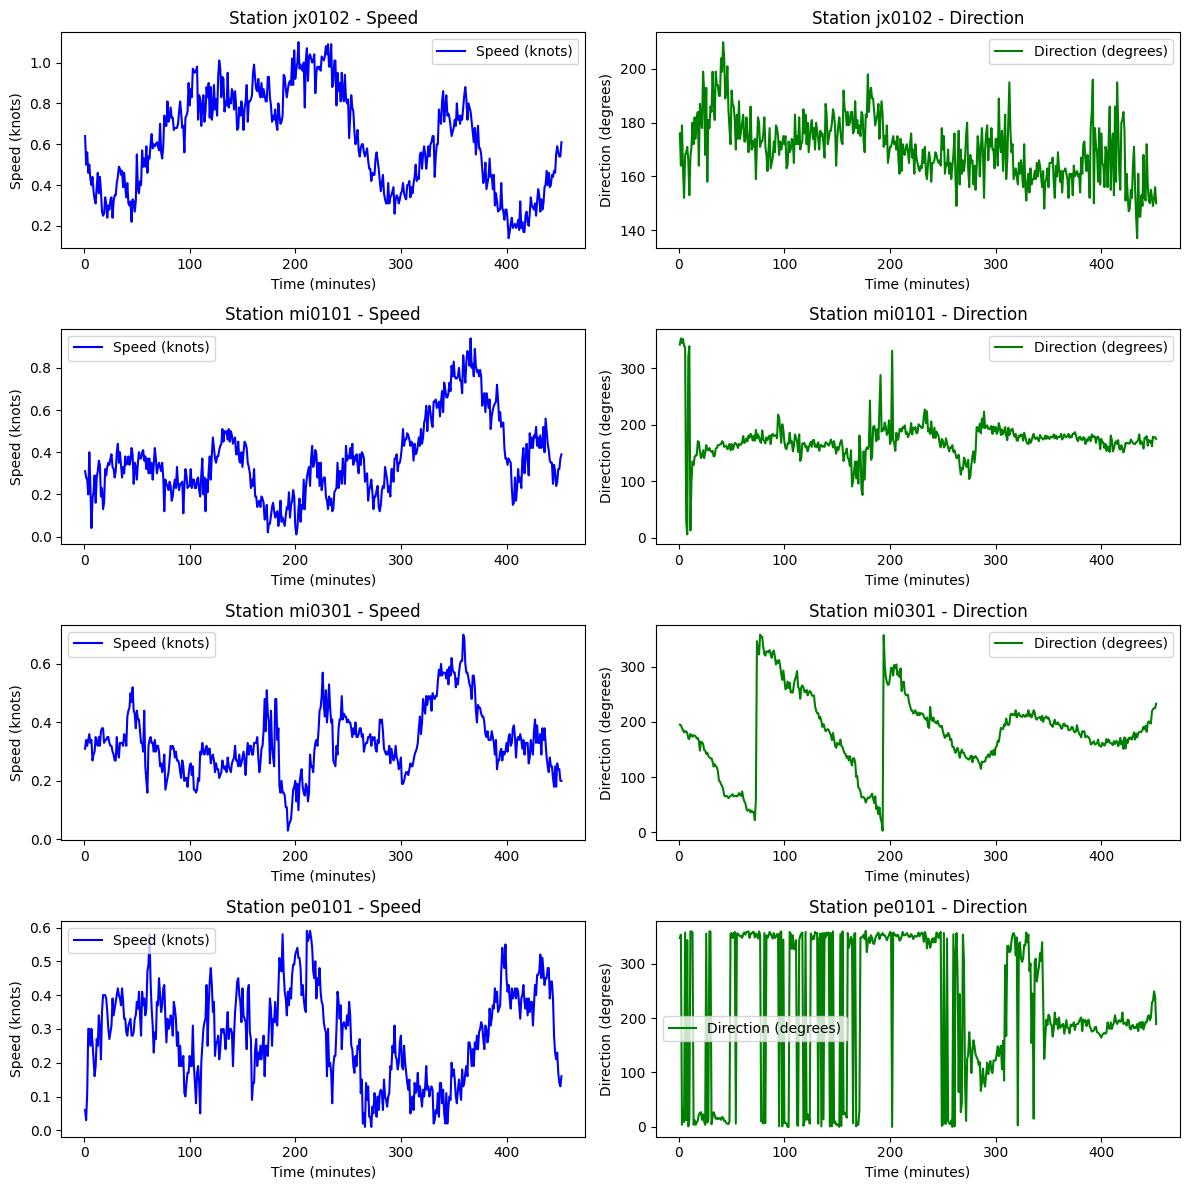

In [4]:
import matplotlib.pyplot as plt
"""
Plots speed and direction over time for each station.
"""
def plot_station_data(time, speed, direction, station_dict):
    num_stations = len(station_dict)
    fig, axs = plt.subplots(num_stations, 2, figsize=(12, 3 * num_stations))

    for i, station in enumerate(station_dict):
        axs[i, 0].plot(time[station], speed[station], label='Speed (knots)', color='blue')
        axs[i, 0].set_title(f'Station {station} - Speed')
        axs[i, 0].set_xlabel('Time (minutes)')
        axs[i, 0].set_ylabel('Speed (knots)')
        axs[i, 0].legend()

        axs[i, 1].plot(time[station], direction[station], label='Direction (degrees)', color='green')
        axs[i, 1].set_title(f'Station {station} - Direction')
        axs[i, 1].set_xlabel('Time (minutes)')
        axs[i, 1].set_ylabel('Direction (degrees)')
        axs[i, 1].legend()

    plt.tight_layout()
    plt.show()

plot_station_data(time, speed, direction, station_dict)


# Kernel Functions

In [5]:
def rbf_kernel(x1, x2, length_scale=1.0):
    sqdist = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return np.exp(-0.5 / length_scale**2 * sqdist)

#
def icm_kernel(x1, x2, output_indices, B, length_scale=1.0):
    """ ICM kernel for multi-output GP with coregionalization matrix B """
    k_space = rbf_kernel(x1, x2, length_scale)
    n = len(x1) * 2 # two outputs

    # full kernel for both outputs
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            output_i, output_j = output_indices[i], output_indices[j]
            K[i, j] = B[output_i, output_j] * k_space[i // 2, j // 2]
    return K

# Normal GP

In [6]:
def gaussian_process(x_train, y_train, x_test, kernel, noise=1e-10):
    """ MVN Gaussian Process model """
    K = kernel(x_train, x_train) + noise * np.eye(len(x_train))
    K_s = kernel(x_train, x_test)
    K_ss = kernel(x_test, x_test) + noise * np.eye(len(x_test))

    K_inv = np.linalg.inv(K)
    mu_s = K_s.T.dot(K_inv).dot(y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s

# Test code
# t = np.arange(1, 101)
# direction_data = {station: np.random.randn(len(t)) for station in station_coords}
# print(direction_data)
# latitudes = np.array([coord['latitude'] for coord in station_coords.values()])
# longitudes = np.array([coord['longitude'] for coord in station_coords.values()])
# x_train = np.column_stack((latitudes, longitudes))

# If you have direction values over time, you may want to reduce it (e.g., mean)
# y_train = np.array([np.mean(direction[station]) for station in station_coords])

# lat_grid, lon_grid = np.meshgrid(np.linspace(latitudes.min() - 0.5, latitudes.max() + 0.5, 50),
#                                  np.linspace(longitudes.min() - 0.5, longitudes.max() + 0.5, 50))
# x_test = np.column_stack([lat_grid.ravel(), lon_grid.ravel()])  # Flatten grid for GP input
# # Run test
# # station_name = 'pe0101'
# # x_train = time.reshape(-1, 1)
# # y_train = direction[station_name]
# # x_test = np.linspace(1, len(y_train), 100).reshape(-1, 1)

# kernel_choice = rbf_kernel
# mu_s, cov_s = gaussian_process(x_train, y_train, x_test, kernel_choice)

[[ 26.09166667 -80.08      ]
 [ 25.76166667 -80.09666667]
 [ 30.39333333 -81.30333333]
 [ 25.76833333 -80.08333333]]


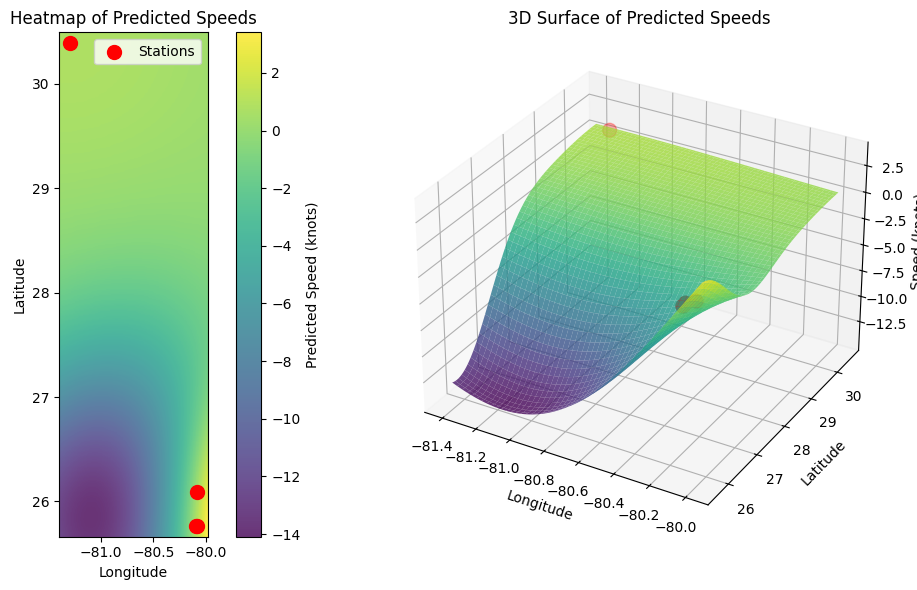

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D

'Plot lat/long fixed time vs velocity'

# Define X, y

# Select one consistent time index across all stations
time_index = random.randint(0, len(next(iter(speed.values()))) - 50)

y_train = np.array([speed[station][time_index] for station in station_coords])

# Lat and long coords
latitudes = np.array([coord['latitude'] for coord in station_coords.values()])
longitudes = np.array([coord['longitude'] for coord in station_coords.values()])
x_train = np.column_stack((latitudes, longitudes))
print(x_train)

# Prediction grid setup
lon_min, lon_max = longitudes.min() - 0.1, longitudes.max() + 0.1
lat_min, lat_max = latitudes.min() - 0.1, latitudes.max() + 0.1
lon_grid, lat_grid = np.meshgrid(np.linspace(lon_min, lon_max, 100), np.linspace(lat_min, lat_max, 100))
x_test = np.column_stack([lat_grid.ravel(), lon_grid.ravel()])

# Run Model
mu_s, cov_s = gaussian_process(x_train, y_train, x_test, rbf_kernel)
predicted_speeds = mu_s.reshape(lon_grid.shape)

plt.figure(figsize=(12, 6))

# Heatmap
plt.subplot(1, 2, 1)
plt.imshow(predicted_speeds, extent=(lon_min, lon_max, lat_min, lat_max), origin='lower', cmap='viridis', alpha=0.8)
plt.colorbar(label='Predicted Speed (knots)')
plt.scatter(longitudes, latitudes, c='r', s=100, label='Stations')
plt.title('Heatmap of Predicted Speeds')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# 3D Surface Plot
ax = plt.subplot(1, 2, 2, projection='3d')
ax.plot_surface(lon_grid, lat_grid, predicted_speeds, cmap='viridis', edgecolor='none', alpha=0.8)
ax.scatter(longitudes, latitudes, y_train, c='r', s=100, label='Stations')
ax.set_title('3D Surface of Predicted Speeds')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Speed (knots)')

plt.tight_layout()
plt.show()

# Vector Valued GP

In [8]:
!pip install gpytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 13.4 MB/s eta 0:00:00


torch.Size([452])
torch.float32
torch.float32
torch.float32
Iter 0/100 - Loss: 1.487
Iter 20/100 - Loss: 1.322
Iter 40/100 - Loss: 1.171
Iter 60/100 - Loss: 1.037
Iter 80/100 - Loss: 0.918


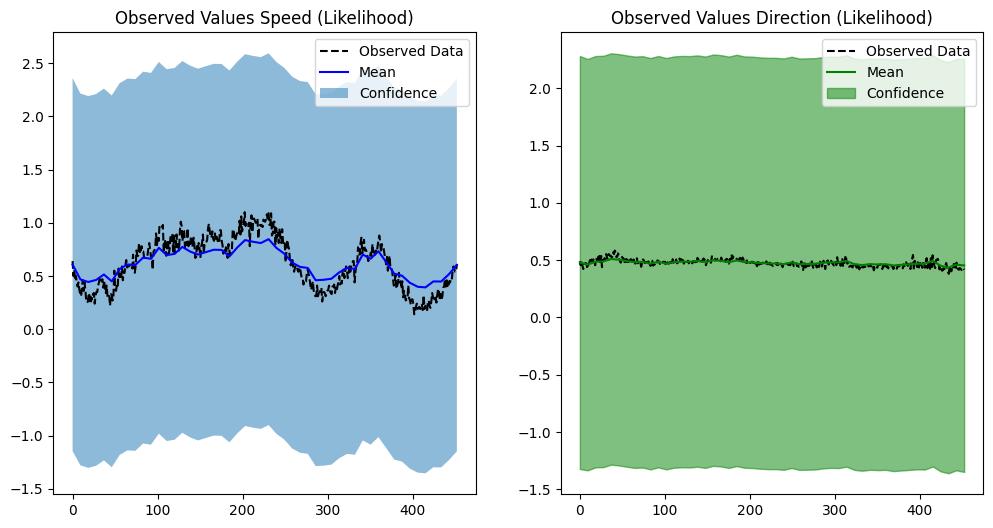

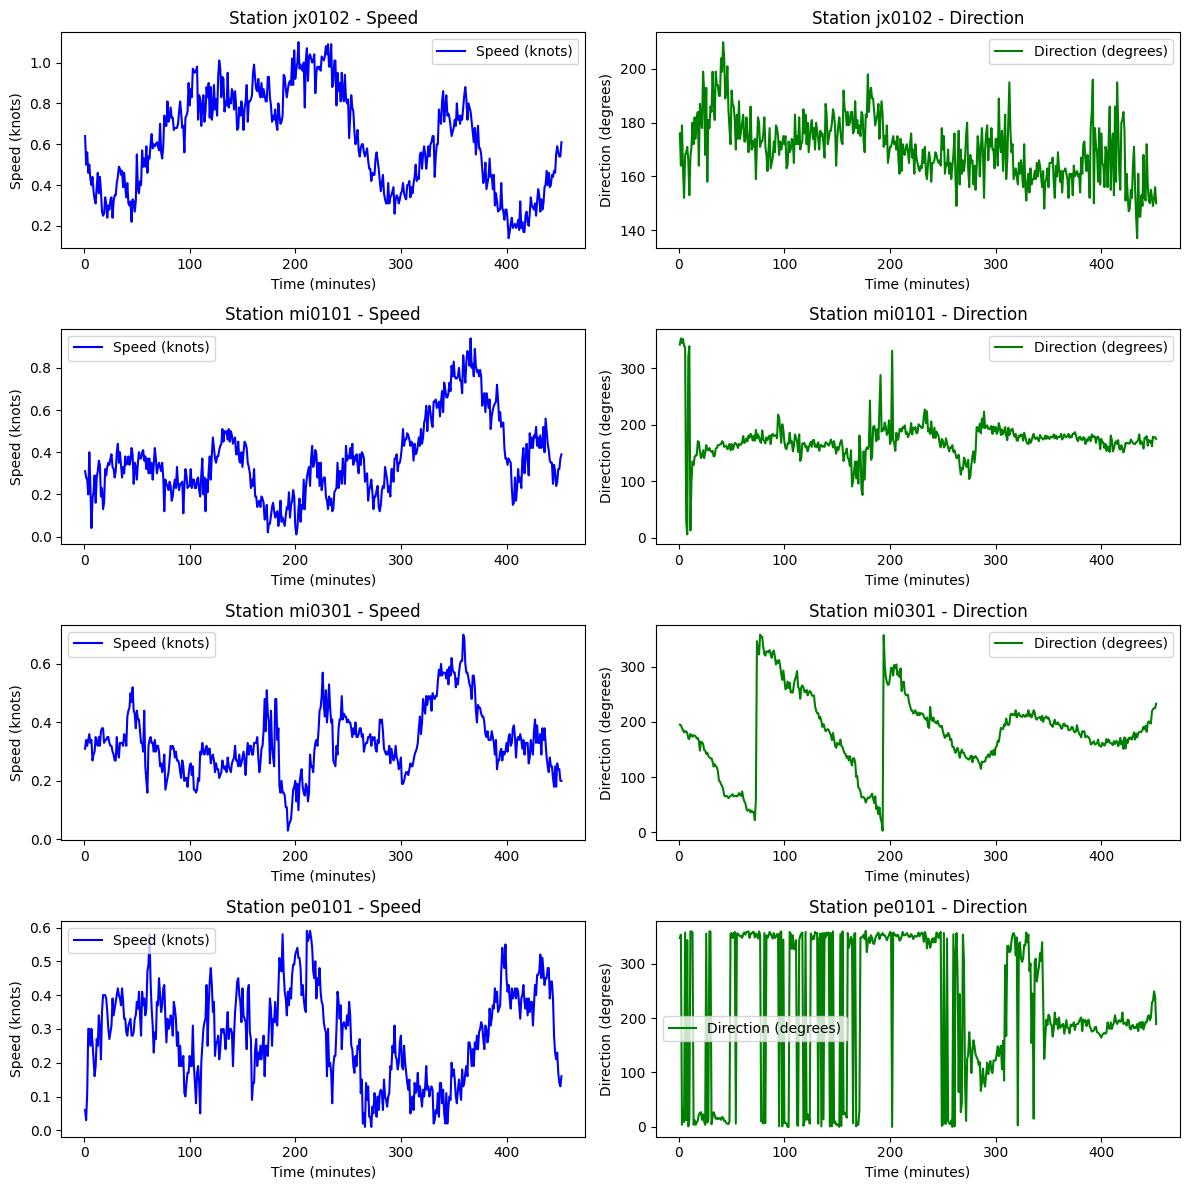

In [9]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


test_points = 50
max_ind = 452
train_x = torch.linspace(0, max_ind, max_ind, dtype=torch.float32)
print(train_x.shape)

# train_y = torch.stack([
#     torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
#     torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
# ], -1)

# t_speed = torch.from_numpy(speed['jx0102'])
# t_direction = torch.from_numpy(direction['jx0102'])

t_speed = torch.tensor(speed['jx0102'][:max_ind], dtype=torch.float32)
t_direction = np.divide(torch.tensor(direction['jx0102'][:max_ind], dtype=torch.float32), 360)

print(train_x.dtype)
print(t_speed.dtype)
print(t_direction.dtype)

train_y = torch.stack([
    t_speed,
    t_direction,
], -1)

#==================== Construct GPy Multitask GPy class
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=2
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


# =========================== Init likelihood and model

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

training_iterations =  100


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # From GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    if (i % 20 == 0):
      print('Iter %d/%d - Loss: %.3f' % (i, training_iterations, loss.item()))
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()


# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, max_ind, test_points)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    # Helper method for 2 sd from the mean
    lower, upper = predictions.confidence_region()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(12, 6))

y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k--')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
# y1_ax.fill_between(test_x.numpy(), np.add(lower[:, 0].numpy(), 3), np.add(upper[:, 0].numpy(), -4), alpha=0.5)
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
# y1_ax.set_ylim([0, 1])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values Speed (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k--')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'g')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5, color='green')
# y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values Direction (Likelihood)')

# print(lower[:, 1].numpy())
# print(upper[:, 1].numpy())

plot_station_data(time, speed, direction, station_dict)

None

In [10]:
# print(lower.shape)
# print(lower)
# print(upper.shape)
# print(upper)
# print(np.add(lower[:, 0].numpy(), 3))
# print(np.add(upper[:, 0].numpy(), -3))
print(likelihood)

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)


x_train
tensor([[  59.8393, -152.3683],
        [  59.8187, -152.1555],
        [  60.0233, -152.1202],
        [  59.7438, -152.0342]])
y_train
tensor([[1.2500, 0.0472],
        [1.8500, 0.0250],
        [1.6800, 0.0778],
        [2.5400, 0.0000]])
Iter 0/100 - Loss: 1.501
Iter 20/100 - Loss: 0.582
Iter 40/100 - Loss: 0.080
Iter 60/100 - Loss: -0.390
Iter 80/100 - Loss: -0.657


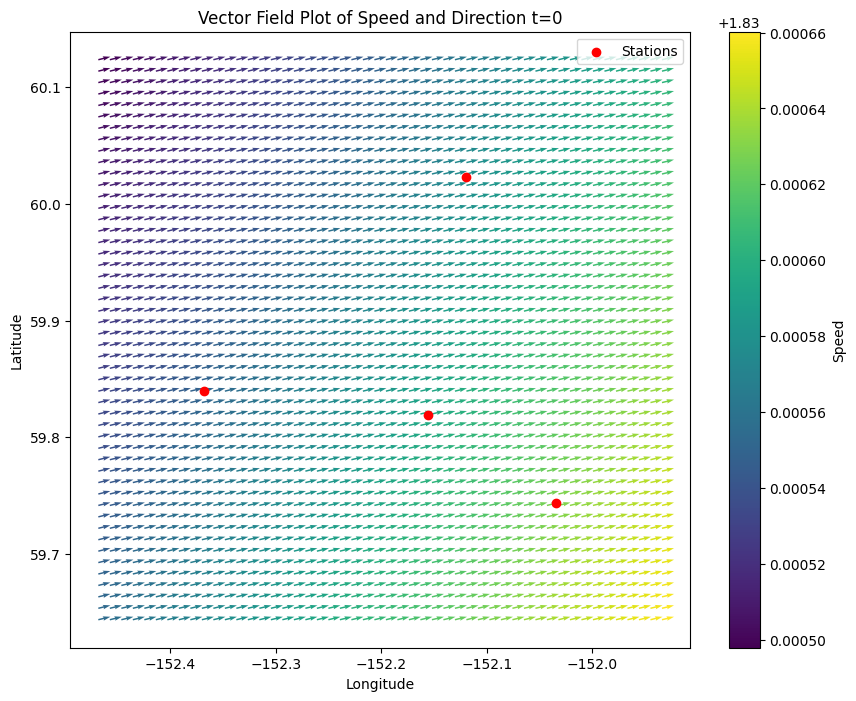

x_train
tensor([[  59.8393, -152.3683],
        [  59.8187, -152.1555],
        [  60.0233, -152.1202],
        [  59.7438, -152.0342]])
y_train
tensor([[1.2300, 0.0333],
        [1.7700, 0.0278],
        [1.8200, 0.0722],
        [2.7100, 0.9972]])
Iter 0/100 - Loss: 1.471
Iter 20/100 - Loss: 0.878
Iter 40/100 - Loss: 0.723
Iter 60/100 - Loss: 0.673
Iter 80/100 - Loss: 0.437


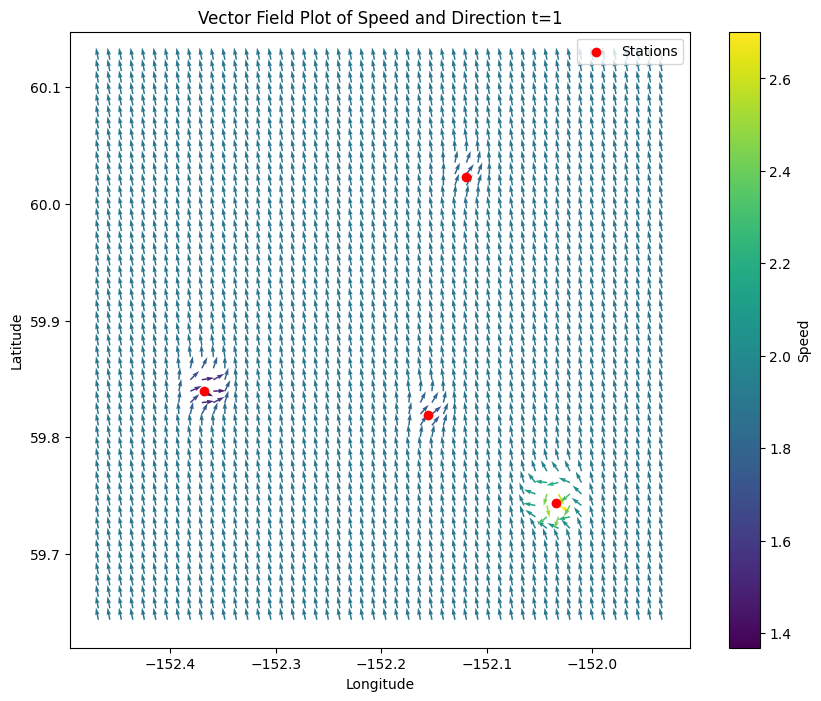

x_train
tensor([[  59.8393, -152.3683],
        [  59.8187, -152.1555],
        [  60.0233, -152.1202],
        [  59.7438, -152.0342]])
y_train
tensor([[1.1700, 0.0500],
        [1.6000, 0.0306],
        [1.8800, 0.0722],
        [2.7100, 1.0000]])
Iter 0/100 - Loss: 1.561
Iter 20/100 - Loss: 0.915
Iter 40/100 - Loss: 0.737
Iter 60/100 - Loss: 0.700
Iter 80/100 - Loss: 0.693


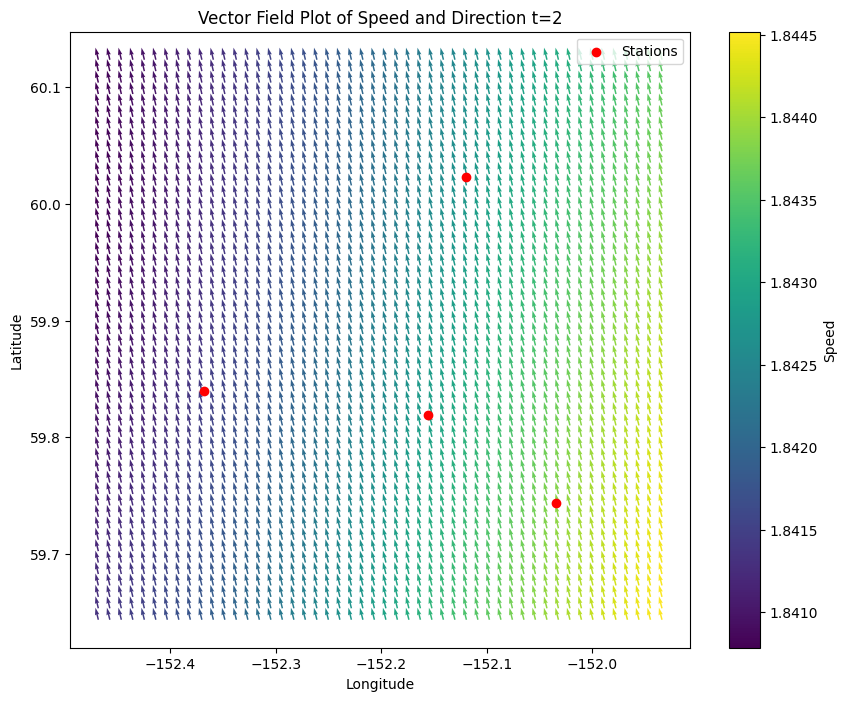

x_train
tensor([[  59.8393, -152.3683],
        [  59.8187, -152.1555],
        [  60.0233, -152.1202],
        [  59.7438, -152.0342]])
y_train
tensor([[1.1000, 0.0417],
        [1.6100, 0.0389],
        [1.9900, 0.0722],
        [2.8800, 1.0000]])
Iter 0/100 - Loss: 1.665
Iter 20/100 - Loss: 0.972
Iter 40/100 - Loss: 0.815
Iter 60/100 - Loss: 0.773
Iter 80/100 - Loss: 0.765


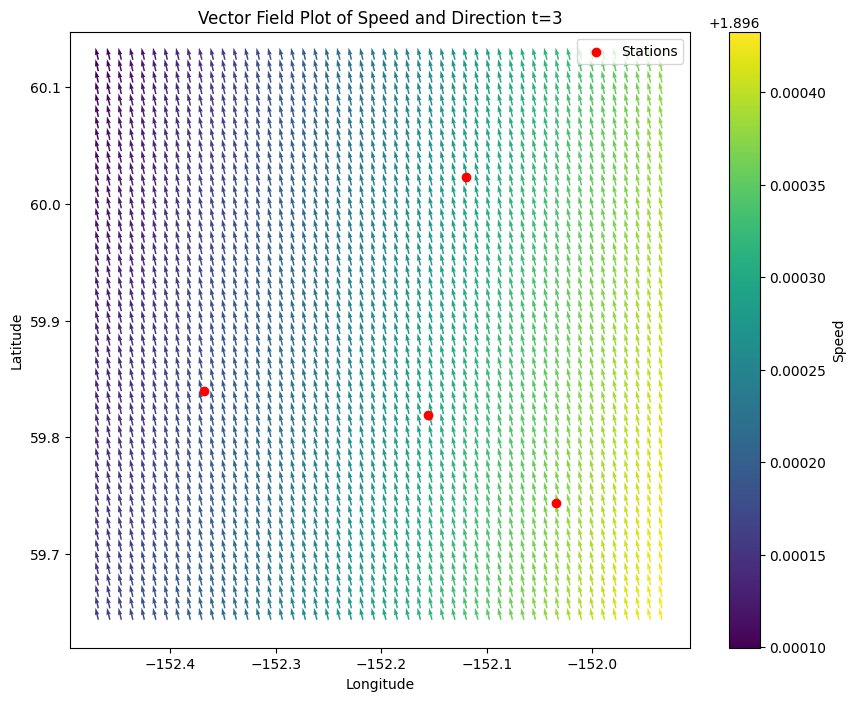

x_train
tensor([[  59.8393, -152.3683],
        [  59.8187, -152.1555],
        [  60.0233, -152.1202],
        [  59.7438, -152.0342]])
y_train
tensor([[1.0900, 0.0306],
        [1.4700, 0.0333],
        [1.9400, 0.0667],
        [2.7900, 0.0000]])
Iter 0/100 - Loss: 1.529
Iter 20/100 - Loss: 0.852
Iter 40/100 - Loss: 0.277
Iter 60/100 - Loss: -0.254
Iter 80/100 - Loss: -0.558


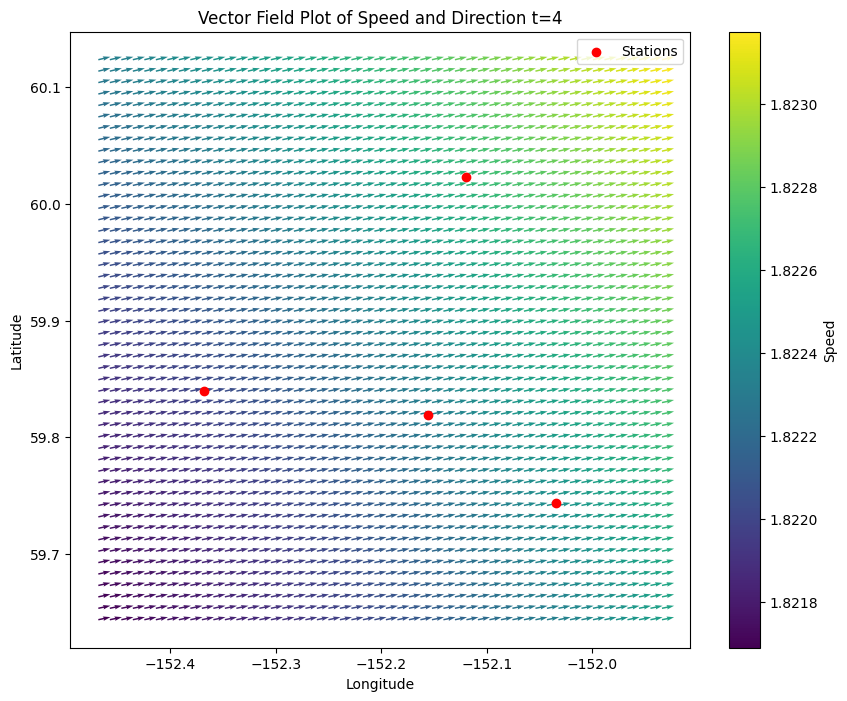

In [15]:
import math
import random
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Test point grid setup
test_points = 50
max_ind = 452
time_index = random.randint(0, max_ind)  # Random time to sample functions at
time_index = 5

for time_index in range(5):
  # Prepare x_train (latitude and longitude coords)
  latitudes = torch.tensor([coord['latitude'] for coord in station_coords.values()])
  longitudes = torch.tensor([coord['longitude'] for coord in station_coords.values()])
  x_train = torch.stack((latitudes, longitudes), dim=1)

  # Prepare y_train for multi-output (speed and direction)
  y_train_speed = torch.tensor([speed[station][time_index] for station in station_coords], dtype=torch.float32)
  y_train_direction = torch.tensor([direction[station][time_index] / 360 for station in station_coords], dtype=torch.float32)
  y_train = torch.stack((y_train_speed, y_train_direction), dim=-1)

  # Prediction grid setup - x_test
  lon_min, lon_max = longitudes.min() - 0.1, longitudes.max() + 0.1
  lat_min, lat_max = latitudes.min() - 0.1, latitudes.max() + 0.1
  lon_grid, lat_grid = np.meshgrid(np.linspace(lon_min, lon_max, test_points), np.linspace(lat_min, lat_max, test_points))
  x_test = torch.tensor(np.column_stack([lat_grid.ravel(), lon_grid.ravel()]), dtype=torch.float32)
  # # Lat and long coords - x_train
  # latitudes = torch.tensor([coord['latitude'] for coord in station_coords.values()])
  # longitudes = torch.tensor([coord['longitude'] for coord in station_coords.values()])
  # x_train = torch.stack((latitudes, longitudes), dim = 1)
  # # x_train = torch.tensor(locations, dtype=torch.float32)
  # # x_train = np.column_stack((latitudes, longitudes))

  # # Vector valued output - y_train
  # y_train_speed = torch.tensor([speed[station][time_index] for station in station_coords], dtype=torch.float32)
  # y_train_direction = np.divide(torch.tensor([direction[station][time_index] for station in station_coords], dtype=torch.float32), 360)
  # # t_speed = torch.tensor(speed['jx0102'][:max_ind], dtype=torch.float32)
  # # t_direction = np.divide(torch.tensor(direction['jx0102'][:max_ind], dtype=torch.float32), 360)

  # # print(train_x.dtype)
  # # print(y_train_speed.dtype)
  # # print(y_train_direction.dtype)

  # y_train = torch.stack([
  #     y_train_speed,
  #     y_train_direction,
  # ], -1)

  print("x_train")
  print(x_train)

  print("y_train")
  print(y_train)

  # Define the multitask GP model
  class MultitaskGPModel(gpytorch.models.ExactGP):
      def __init__(self, train_x, train_y, likelihood):
          super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
          self.mean_module = gpytorch.means.MultitaskMean(
              gpytorch.means.ConstantMean(), num_tasks=2
          )
          self.covar_module = gpytorch.kernels.MultitaskKernel(
              gpytorch.kernels.RBFKernel(), num_tasks=2, rank=2
          )

      def forward(self, x):
          mean_x = self.mean_module(x)
          covar_x = self.covar_module(x)
          return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

  # likelihood and model
  likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
  model = MultitaskGPModel(x_train, y_train, likelihood)

  # Training
  training_iterations = 100

  model.train()
  likelihood.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

  for i in range(training_iterations):
      optimizer.zero_grad()
      output = model(x_train)
      loss = -mll(output, y_train)
      loss.backward()
      if i % 20 == 0:
          print(f"Iter {i}/{training_iterations} - Loss: {loss.item():.3f}")
      optimizer.step()

  # Prediction
  model.eval()
  likelihood.eval()

  # Make predictions on the x_test grid
  with torch.no_grad(), gpytorch.settings.fast_pred_var():
      predictions = likelihood(model(x_test))
      mean = predictions.mean
      lower, upper = predictions.confidence_region()

  # Separate the predictions for speed and direction
  speed_mean = mean[:, 0].reshape(test_points, test_points).numpy()
  direction_mean = mean[:, 1].reshape(test_points, test_points).numpy()

  # # Plotting Heatmap of Speed and Direction with station markers
  # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

  # # Speed heatmap
  # c1 = ax1.imshow(speed_mean, extent=(lon_min, lon_max, lat_min, lat_max), origin="lower", aspect="auto")
  # ax1.scatter(longitudes, latitudes, color='red', marker='o', s=50, label="Stations")
  # ax1.set_title("Predicted Speed Heatmap")
  # ax1.set_xlabel("Longitude")
  # ax1.set_ylabel("Latitude")
  # ax1.legend()
  # fig.colorbar(c1, ax=ax1, label="Speed")

  # # Direction heatmap
  # c2 = ax2.imshow(direction_mean, extent=(lon_min, lon_max, lat_min, lat_max), origin="lower", aspect="auto")
  # ax2.scatter(longitudes, latitudes, color='red', marker='o', s=50, label="Stations")
  # ax2.set_title("Predicted Direction Heatmap")
  # ax2.set_xlabel("Longitude")
  # ax2.set_ylabel("Latitude")
  # ax2.legend()
  # fig.colorbar(c2, ax=ax2, label="Direction (normalized)")

  # # Plotting 3D Surface for Speed with station markers
  # fig = plt.figure(figsize=(12, 6))
  # ax = fig.add_subplot(121, projection="3d")
  # ax.plot_surface(lon_grid, lat_grid, speed_mean, cmap="viridis", edgecolor="none")
  # ax.scatter(longitudes, latitudes, y_train_speed.numpy(), color='red', marker='o', s=50, label="Stations")
  # ax.set_title("Predicted Speed 3D Surface")
  # ax.set_xlabel("Longitude")
  # ax.set_ylabel("Latitude")
  # ax.set_zlabel("Speed")
  # ax.legend()

  # # Plotting 3D Surface for Direction with station markers
  # ax = fig.add_subplot(122, projection="3d")
  # ax.plot_surface(lon_grid, lat_grid, direction_mean, cmap="plasma", edgecolor="none")
  # ax.scatter(longitudes, latitudes, y_train_direction.numpy(), color='red', marker='o', s=50, label="Stations")
  # ax.set_title("Predicted Direction 3D Surface")
  # ax.set_xlabel("Longitude")
  # ax.set_ylabel("Latitude")
  # ax.set_zlabel("Direction (normalized)")
  # ax.legend()

  # plt.show()

  # Compute the x and y components of the arrows based on the direction

  # un-normalize the degree function and convert to radians for direction vector
  direction_rad = np.deg2rad(np.multiply(direction_mean, 360))
  u = np.cos(direction_rad)  # x-component of direction
  v = np.sin(direction_rad)  # y-component of direction

  # Plot the vector field
  plt.figure(figsize=(10, 8))
  plt.quiver(lon_grid, lat_grid, u, v, speed_mean, cmap="viridis", scale=50, headwidth=3)
  plt.colorbar(label="Speed")
  plt.scatter(longitudes, latitudes, color="red", marker="o", label="Stations")
  plt.xlabel("Longitude")
  plt.ylabel("Latitude")
  plt.title(f"Vector Field Plot of Speed and Direction t={time_index}")
  plt.legend()

  plt.show()

In [12]:
# Vector valued GP ICM Implementation
def vector_gaussian_process(x_train, y_train, x_test, kernel, output_indices, B, noise=1e-10):
    """ Multi-output Gaussian Process model with ICM kernel """
    K = kernel(x_train, x_train, output_indices, B) + noise * np.eye(len(y_train))
    K_s = kernel(x_train, x_test, output_indices, B)[:len(y_train), :len(x_test) * 2]
    K_ss = kernel(x_test, x_test, output_indices, B)[:len(x_test) * 2, :len(x_test) * 2] + noise * np.eye(len(x_test) * 2)

    K_inv = np.linalg.inv(K)
    mu_s = K_s.T.dot(K_inv).dot(y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

    return mu_s, cov_s


ICM

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import random

# # Time period - mi0101 has the smallest set of points right now
time_index = random.randint(0, len(time['mi0101']) - 1)

# Prepare training data for multi-output GP
x_train = []
y_train = []
output_indices = []

for i, station in enumerate(station_dict):
    coord = station_coords[station]
    x_train.append([coord['latitude'], coord['longitude']])
    y_train.append([speed[station][time_index], direction[station][time_index]])
    output_indices += [0, 1]  # 0 for speed, 1 for direction

# x_train = np.array(x_train)
# y_train = np.array(y_train).flatten()

# # init a random B vector
# B = np.array([[1.0, 0.5], [0.5, 1.0]])

# # Prediction grid setup for spatial locations
# latitudes = np.array([coord['latitude'] for coord in station_coords.values()])
# longitudes = np.array([coord['longitude'] for coord in station_coords.values()])
# lon_min, lon_max = longitudes.min() - 0.1, longitudes.max() + 0.1
# lat_min, lat_max = latitudes.min() - 0.1, latitudes.max() + 0.1
# lon_grid, lat_grid = np.meshgrid(np.linspace(lon_min, lon_max, 100), np.linspace(lat_min, lat_max, 100))
# x_test = np.column_stack([lat_grid.ravel(), lon_grid.ravel()])

# # Train cross-cov GP
# mu_s, cov_s = vector_gaussian_process(x_train, y_train, x_test, icm_kernel, output_indices, B)

# # Reshape predictions for plotting
# predicted_speeds = mu_s[::2].reshape(lon_grid.shape)
# predicted_directions = mu_s[1::2].reshape(lon_grid.shape)



# plt.figure(figsize=(12, 6))

# # 3D Surface speeds
# ax = plt.subplot(1, 2, 1, projection='3d')
# ax.plot_surface(lon_grid, lat_grid, predicted_speeds, cmap='viridis', edgecolor='none', alpha=0.8)
# ax.scatter(longitudes, latitudes, y_train[1::2], c='r', s=100, label='Stations')
# ax.set_title('3D Surface of Predicted Directions')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.set_zlabel('Direction (degrees)')

# # 3D Surface directions
# ax = plt.subplot(1, 2, 2, projection='3d')
# ax.plot_surface(lon_grid, lat_grid, predicted_directions, cmap='viridis', edgecolor='none', alpha=0.8)
# ax.scatter(longitudes, latitudes, y_train[1::2], c='r', s=100, label='Stations')
# ax.set_title('3D Surface of Predicted Directions')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.set_zlabel('Direction (degrees)')

# plt.tight_layout()
# plt.show()